# Dataset import and exploration
- https://www.kaggle.com/shree1992/housedata

In [45]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

# suppress cell warnings
import warnings
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv('zindi_dataset/clean_income_dataset.csv')
df.sample(5)

,Unnamed: 0,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
3126,3126,ID_feb43b86a96ab5c716ddd533a43606f00270e30c6ce...,2022-03,"20,000",2022-08,0,16,7,1,21
2396,2396,ID_5b49db8c669235b3abfdb3ba385d6df0db1ec3d0375...,2022-07,"7,400",2022-09,1,9,8,1,33
1508,1508,ID_42d1a97895fe3466565aac9f580df6c71f7a6b9c10f...,2022-07,"6,500",2022-08,0,8,4,1,34
3580,3580,ID_7efab270ad3520a9775ebb21ebbd61259e90eee26b9...,2022-07,"14,000",2022-09,1,14,12,1,22
1786,1786,ID_4e97207421fc6ec201db33eba130f2b677971019235...,2022-04,"27,000",2022-07,0,17,10,1,44


In [47]:
df.shape

(5144, 10)

In [48]:
df.isnull().sum()

Unnamed: 0                     0
CUSTOMER_IDENTIFIER            0
RECORD_DATE                    0
DECLARED_NET_INCOME         1544
DATE_LAST_UPDATED              0
SEX_CODE                       0
INCOME_GROUP_CODE              0
NUMBER_OF_ACCOUNTS             0
OCCUPATIONAL_STATUS_CODE       0
AGE                            0
dtype: int64

<br>

# Drop columns we won't need

In [49]:
to_drop = ['CUSTOMER_IDENTIFIER', 'Unnamed: 0', 'RECORD_DATE', 'DATE_LAST_UPDATED']
df = df.drop(to_drop, axis=1)
df.head()

,DECLARED_NET_INCOME,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,"13,500",0,15,7,1,45
1,"9,000",0,15,5,1,32
2,"8,000",0,7,7,7,59
3,"7,000",1,9,14,7,57
4,"10,400",0,12,11,1,29


In [50]:
df.tail()

,DECLARED_NET_INCOME,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
5139,NaN,1,13,22,1,33
5140,NaN,0,6,5,1,48
5141,NaN,1,14,19,1,41
5142,NaN,1,13,3,1,22
5143,NaN,1,16,6,1,22


<br>

# Feature engineering

- Houses that weren't renovated have `yr_renovated = 0`
- Here's how to get the first renovation year

- Let's create a couple of features:
    - House age 
    - Was the house renovated?
    - Was the renovation recent? (10 years or less)
    - Was the renovation not that recent (more than 10 years but less than 30)
- We'll then drop the original features

- A lot of City options

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DECLARED_NET_INCOME       3600 non-null   object
 1   SEX_CODE                  5144 non-null   int64 
 2   INCOME_GROUP_CODE         5144 non-null   int64 
 3   NUMBER_OF_ACCOUNTS        5144 non-null   int64 
 4   OCCUPATIONAL_STATUS_CODE  5144 non-null   int64 
 5   AGE                       5144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 241.2+ KB


- Let's declare a function that will get rid of all city values that don't occur often
- The original value will be replaced with 'Rare':

<br>

# Target variable visualization

In [58]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [ ]:
plt.hist(df['DECLARED_NET_INCOME']);

- The distribution is highly skewed, so let's calculate Z-scores and remove outliers (assume the distirbution is otherwise normal)

- Still a bit of skew present
- There seem to be houses selling for $0
    - Let's remove them:

<br>

# Data preparation for ML

- We'll MinMaxScale the numerical features and one-hot encode the categorical ones
- The features `waterfront`, `was_renovated`, `was_renovated_10_yrs` and `was_renovated_30_yrs` are ignored, since they're already in (0, 1) format

In [60]:
df['DECLARED_NET_INCOME'] = df['DECLARED_NET_INCOME'].str.replace(r'\D', '')
df['DECLARED_NET_INCOME'] = df['DECLARED_NET_INCOME'].astype('float32')

- Train/test split - 80:20:

In [69]:
train_df = df[df.DECLARED_NET_INCOME.notnull()]
test_df = df[df.DECLARED_NET_INCOME.isnull()]

In [77]:
test_df = test_df.drop('DECLARED_NET_INCOME', axis=1)

In [78]:
test_df.head()

,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
3600,1,17,19,1,28
3601,0,12,11,1,40
3602,0,16,8,1,32
3603,1,2,6,1,45
3604,0,9,13,1,29


In [79]:
train_df.head()

,DECLARED_NET_INCOME,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,13500.0,0,15,7,1,45
1,9000.0,0,15,5,1,32
2,8000.0,0,7,7,7,59
3,7000.0,1,9,14,7,57
4,10400.0,0,12,11,1,29


In [80]:
from sklearn.model_selection import train_test_split

X = train_df.drop('DECLARED_NET_INCOME', axis=1)
y = train_df['DECLARED_NET_INCOME']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)
X_train.shape, X_test.shape

((3582, 5), (18, 5))

- Let's apply the transformations:

- Sparse array format:

In [83]:
y_train.astype('float32')
X_train

,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
270,1,13,21,1,43
1965,0,5,11,1,39
879,0,13,13,1,26
1924,0,11,10,1,42
1057,1,16,12,1,31
...,...,...,...,...,...
1130,0,6,7,1,26
1294,0,13,5,1,37
860,0,12,7,1,43
3507,0,12,4,1,46


- Convert to array:

<br>

# Model training

In [86]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

- RMSE is the best metric, as the error is displayed in the same units the target variable is in

In [87]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

- Really simple model:

In [88]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    loss=rmse,
    optimizer=Adam(),
    metrics=[rmse]
)

model.fit(X_train, y_train, epochs=200)

Epoch 1/200
112/112 [==============================] - 1s 2ms/step - loss: 13153.6475 - rmse: 13152.7373
Epoch 2/200
112/112 [==============================] - 0s 2ms/step - loss: 9000.4844 - rmse: 9000.0752
Epoch 3/200
112/112 [==============================] - 0s 2ms/step - loss: 8104.0015 - rmse: 8102.4780
Epoch 4/200
112/112 [==============================] - 0s 2ms/step - loss: 7531.8086 - rmse: 7530.5811
Epoch 5/200
112/112 [==============================] - 0s 2ms/step - loss: 7378.5083 - rmse: 7377.4268
Epoch 6/200
112/112 [==============================] - 0s 2ms/step - loss: 7349.1333 - rmse: 7351.8804
Epoch 7/200
112/112 [==============================] - 0s 2ms/step - loss: 7314.0713 - rmse: 7313.6880
Epoch 8/200
112/112 [==============================] - 0s 2ms/step - loss: 7248.0034 - rmse: 7246.8140
Epoch 9/200
112/112 [==============================] - 0s 2ms/step - loss: 7234.4126 - rmse: 7237.1104
Epoch 10/200
112/112 [==============================] - 0s 2ms/step - l

112/112 [==============================] - 0s 2ms/step - loss: 6040.8809 - rmse: 6039.9297
Epoch 158/200
112/112 [==============================] - 0s 2ms/step - loss: 6092.1621 - rmse: 6091.2808
Epoch 159/200
112/112 [==============================] - 0s 2ms/step - loss: 6022.7153 - rmse: 6022.4102
Epoch 160/200
112/112 [==============================] - 0s 2ms/step - loss: 6004.0508 - rmse: 6004.1758
Epoch 161/200
112/112 [==============================] - 0s 2ms/step - loss: 6113.3882 - rmse: 6113.4141
Epoch 162/200
112/112 [==============================] - 0s 2ms/step - loss: 6060.2310 - rmse: 6059.9424
Epoch 163/200
112/112 [==============================] - 0s 2ms/step - loss: 6020.6665 - rmse: 6024.1250
Epoch 164/200
112/112 [==============================] - 0s 2ms/step - loss: 6071.1182 - rmse: 6071.4888
Epoch 165/200
112/112 [==============================] - 0s 2ms/step - loss: 6042.9624 - rmse: 6041.3481
Epoch 166/200
112/112 [==============================] - 0s 2ms/step 

<br>

- Predict on the test set:

In [89]:
pd.DataFrame(model.history.history)

,loss,rmse
0,13153.647461,13152.737305
1,9000.484375,9000.075195
2,8104.001465,8102.478027
3,7531.808594,7530.581055
4,7378.508301,7377.426758
...,...,...
195,6023.278809,6023.495117
196,5981.152832,5979.970215
197,6052.718750,6052.475586
198,5994.069336,5993.665039


<AxesSubplot: >

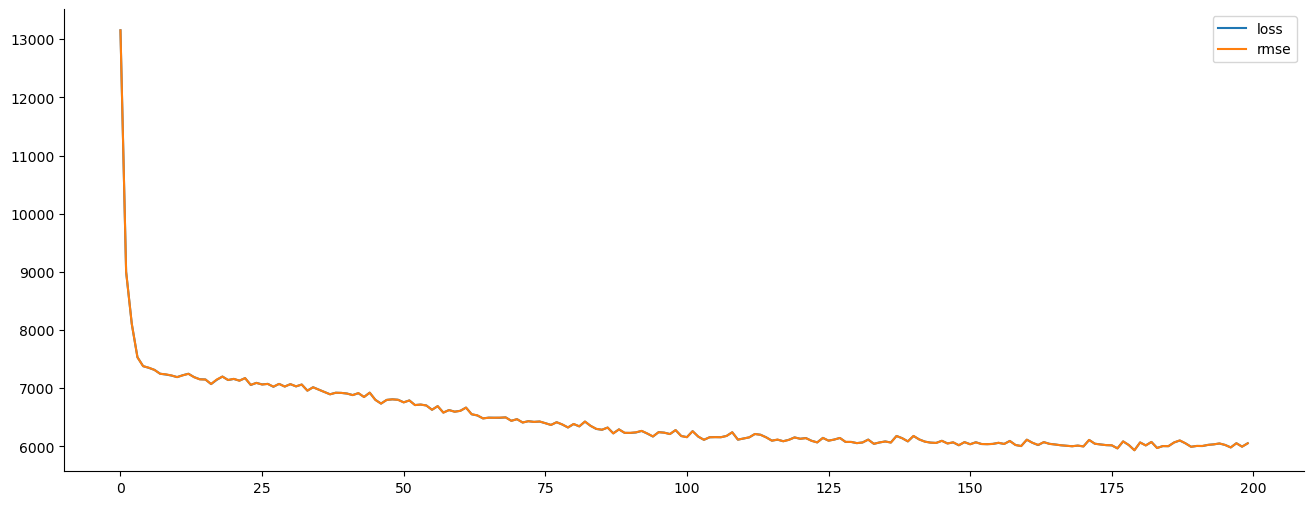

In [90]:
pd.DataFrame(model.history.history).plot()

#### Early Stopping

In [37]:
help(EarlyStopping)

Help on class EarlyStopping in module keras.callbacks:

class EarlyStopping(Callback)
 |  EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
 |  
 |  Stop training when a monitored metric has stopped improving.
 |  
 |  Assuming the goal of a training is to minimize the loss. With this, the
 |  metric to be monitored would be `'loss'`, and mode would be `'min'`. A
 |  `model.fit()` training loop will check at end of every epoch whether
 |  the loss is no longer decreasing, considering the `min_delta` and
 |  `patience` if applicable. Once it's found no longer decreasing,
 |  `model.stop_training` is marked True and the training terminates.
 |  
 |  The quantity to be monitored needs to be available in `logs` dict.
 |  To make it so, pass the loss or metrics at `model.compile()`.
 |  
 |  Args:
 |    monitor: Quantity to be monitored.
 |    min_delta: Minimum change in the monitored quantity
 

In [96]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=2,patience=25)

In [97]:
model.fit(x=X_train,y=y_train,epochs=600,
          validation_data=(X_test,y_test),
          callbacks=[early_stop])

Epoch 1/600
112/112 [==============================] - 0s 3ms/step - loss: 6000.5957 - rmse: 6003.6382 - val_loss: 5504.0898 - val_rmse: 5504.0898
Epoch 2/600
112/112 [==============================] - 0s 2ms/step - loss: 6060.3887 - rmse: 6060.3716 - val_loss: 5197.0059 - val_rmse: 5197.0059
Epoch 3/600
112/112 [==============================] - 0s 2ms/step - loss: 6060.6411 - rmse: 6058.8486 - val_loss: 5440.7085 - val_rmse: 5440.7085
Epoch 4/600
112/112 [==============================] - 0s 2ms/step - loss: 5967.8643 - rmse: 5966.7510 - val_loss: 5321.9443 - val_rmse: 5321.9443
Epoch 5/600
112/112 [==============================] - 0s 2ms/step - loss: 5992.8574 - rmse: 5992.2866 - val_loss: 5398.3975 - val_rmse: 5398.3975
Epoch 6/600
112/112 [==============================] - 0s 2ms/step - loss: 5984.3726 - rmse: 5985.0464 - val_loss: 5275.9165 - val_rmse: 5275.9165
Epoch 7/600
112/112 [==============================] - 0s 2ms/step - loss: 6023.2905 - rmse: 6022.8369 - val_loss: 518

<AxesSubplot: >

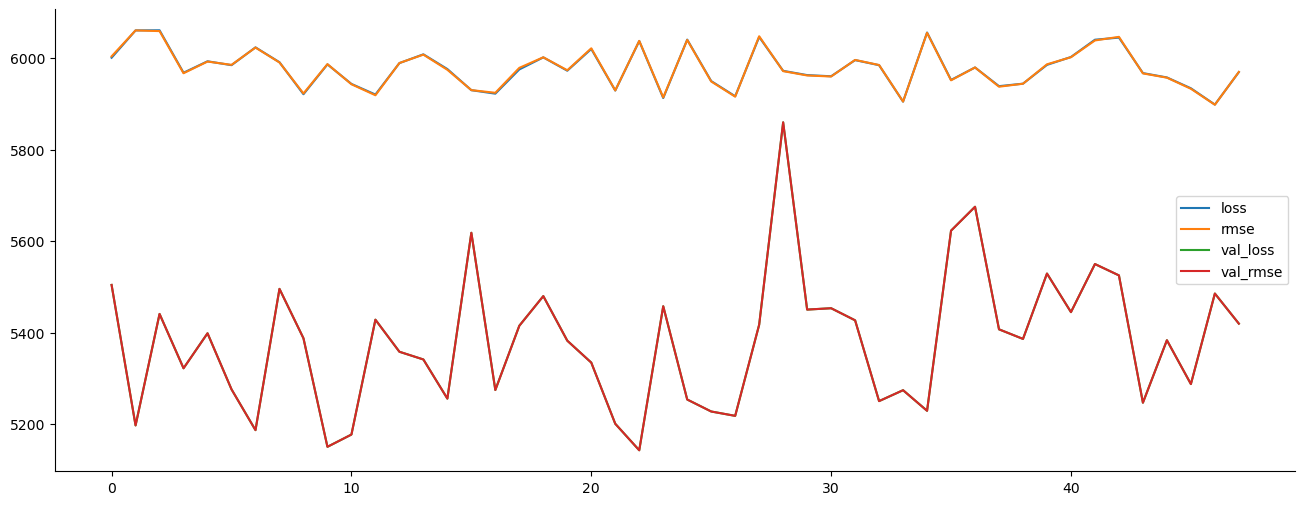

In [98]:
pd.DataFrame(model.history.history).plot()

In [99]:
predictions = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [100]:
predictions[:5]

array([[ 7669.475 ],
       [ 6768.0356],
       [ 8309.097 ],
       [ 6483.545 ],
       [12153.181 ]], dtype=float32)

- Convert to a 1D array before visualization:

In [101]:
predictions = np.ravel(predictions)
predictions[:5]

array([ 7669.475 ,  6768.0356,  8309.097 ,  6483.545 , 12153.181 ],
      dtype=float32)

In [102]:
rmse(y_test, predictions).numpy()

5419.479

#### for test_df

In [111]:
test_predictions = model.predict(test_df)

49/49 [==============================] - 0s 1ms/step


In [112]:
test_predictions = np.ravel(test_predictions)

In [115]:
df_test = pd.read_csv("zindi_dataset/SampleSubmission.csv")
cus_id = df_test['CUSTOMER_IDENTIFIER']

In [117]:
# add predicted x_test to df
df_test['DECLARED_NET_INCOME'] = test_predictions

In [118]:
df_test.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,31974.179688
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,10920.305664
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,23544.312500
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,8229.198242
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,8208.751953


In [119]:
df_test.to_csv('predicted_net_income.csv', index = False)